In [10]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [11]:
# Load a real-world weather dataset
# For demonstration, we'll simulate data if no real dataset is provided.
# Example data format: Date, Temperature (°C), Humidity (%), Weather (Sunny, Rainy, etc.)
try:
    # Attempting to load the dataset (replace with your local file if available)
    weather_df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")
    weather_df.columns = ['Date', 'Temperature']
    weather_df['Humidity'] = np.random.randint(30, 90, len(weather_df))  # Simulating humidity
    weather_df['Weather'] = np.random.choice(['Sunny', 'Rainy', 'Cloudy'], len(weather_df), p=[0.5, 0.3, 0.2])
except:
    # Simulated dataset
    weather_df = pd.DataFrame({
        'Date': pd.date_range(start='1/1/2023', periods=10),
        'Temperature': [25, 18, 22, 30, 27, 19, 23, 20, 24, 21],
        'Humidity': [60, 80, 75, 50, 55, 85, 70, 78, 65, 72],
        'Weather': ['Sunny', 'Rainy', 'Cloudy', 'Sunny', 'Sunny', 'Rainy', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy']
    })


In [12]:

# Preprocess the data
le = LabelEncoder()
weather_df['Weather_Label'] = le.fit_transform(weather_df['Weather'])

# Define hidden states and observations
hidden_states = le.classes_  # ['Cloudy', 'Rainy', 'Sunny']
n_states = len(hidden_states)

observations = ['High Temp, Low Humidity', 'Low Temp, High Humidity', 'Moderate Temp, Moderate Humidity']
n_observations = len(observations)

# Simulate transition and emission probabilities
transition_matrix = np.array([
    [0.7, 0.2, 0.1],  # Cloudy -> Cloudy, Rainy, Sunny
    [0.3, 0.5, 0.2],  # Rainy -> Cloudy, Rainy, Sunny
    [0.1, 0.3, 0.6],  # Sunny -> Cloudy, Rainy, Sunny
])

emission_matrix = np.array([
    [0.3, 0.5, 0.2],  # Cloudy -> High, Low, Moderate
    [0.1, 0.7, 0.2],  # Rainy -> High, Low, Moderate
    [0.6, 0.2, 0.2],  # Sunny -> High, Low, Moderate
])

initial_probabilities = np.array([0.3, 0.4, 0.3])  # Initial probabilities for Cloudy, Rainy, Sunny

In [13]:
# Generate observation sequence based on real data
observation_sequence = weather_df['Weather_Label'].values
# Viterbi Algorithm Implementation
def viterbi(obs, states, start_prob, trans_prob, emis_prob):
    T = len(obs)  # Define the number of observations
    N = len(states)  # Number of states
    
    # Initialize DP table and path tracker
    dp = np.zeros((N, T))  # DP table to store probabilities
    path = np.zeros((N, T), dtype=int)  # Path table to store most probable previous states
    
    # Initialize base cases (t = 0)
    dp[:, 0] = start_prob * emis_prob[:, obs[0]]  # Initial probabilities at t=0
    
    # DP recursion for all time steps (t > 0)
    for t in range(1, T):
        for s in range(N):
            prob = dp[:, t-1] * trans_prob[:, s] * emis_prob[s, obs[t]]  # Calculate probabilities
            dp[s, t] = np.max(prob)  # Store the max probability
            path[s, t] = np.argmax(prob)  # Store the state that gave the max probability
    
    # Backtrack to find the most probable path (state sequence)
    best_path = np.zeros(T, dtype=int)  # Array to store the most probable path
    best_path[-1] = np.argmax(dp[:, -1])  # Start from the last column
    for t in range(T-2, -1, -1):  # Backtrack from the second-to-last time step
        best_path[t] = path[best_path[t+1], t+1]  # Set the best path for this time step
    
    return best_path, dp
    

In [14]:
# Run the Viterbi algorithm
most_probable_states, dp_table = viterbi(observation_sequence, np.arange(n_states), initial_probabilities, transition_matrix, emission_matrix)

# Map hidden state indices back to labels
most_probable_weather = [hidden_states[state] for state in most_probable_states]

# Add results to the DataFrame
weather_df['Predicted_Weather'] = most_probable_weather

# Display the results
weather_df[['Date', 'Temperature', 'Humidity', 'Weather', 'Predicted_Weather']]

,Date,Temperature,Humidity,Weather,Predicted_Weather
0,1981-01-01,20.7,83,Sunny,Cloudy
1,1981-01-02,17.9,75,Sunny,Cloudy
2,1981-01-03,18.8,49,Rainy,Cloudy
3,1981-01-04,14.6,44,Cloudy,Cloudy
4,1981-01-05,15.8,48,Sunny,Cloudy
...,...,...,...,...,...
3645,1990-12-27,14.0,33,Cloudy,Cloudy
3646,1990-12-28,13.6,51,Sunny,Cloudy
3647,1990-12-29,13.5,36,Cloudy,Cloudy
3648,1990-12-30,15.7,78,Sunny,Cloudy


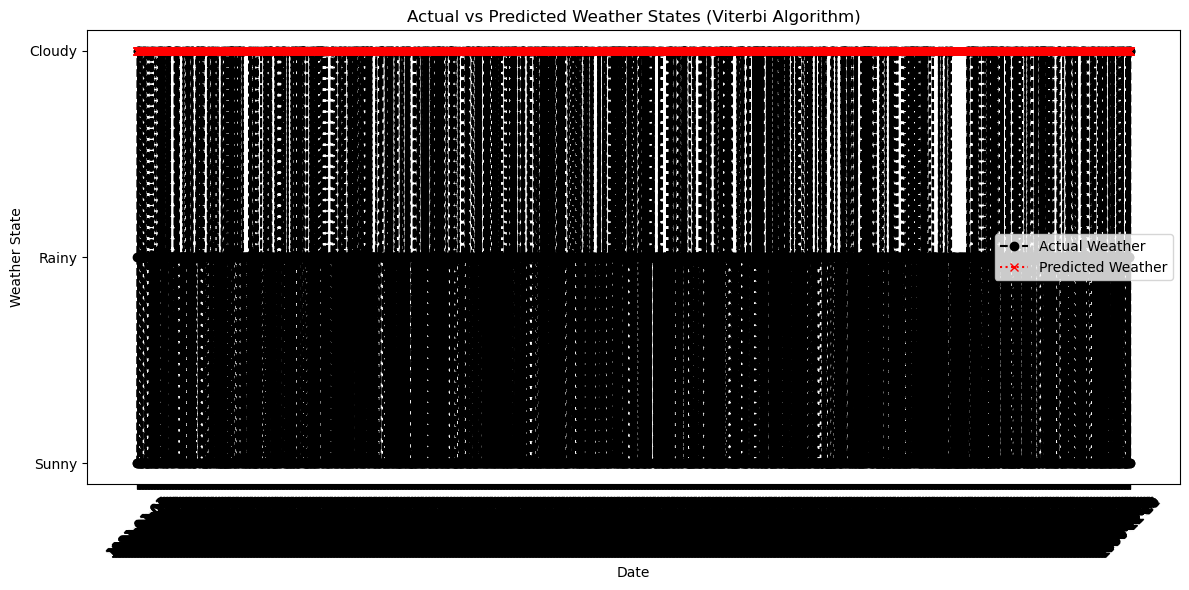

In [15]:
# Importing the plotting library
import matplotlib.pyplot as plt

# Map weather labels to colors for better visualization
weather_colors = {
    'Cloudy': 'gray',
    'Rainy': 'blue',
    'Sunny': 'yellow'
}

# Plot the actual vs predicted weather states
plt.figure(figsize=(12, 6))

# Plotting the actual weather states
plt.plot(weather_df['Date'], weather_df['Weather'], label='Actual Weather', color='black', marker='o', linestyle='--')

# Plotting the predicted weather states
plt.plot(weather_df['Date'], weather_df['Predicted_Weather'], label='Predicted Weather', color='red', marker='x', linestyle=':')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Weather State')
plt.title('Actual vs Predicted Weather States (Viterbi Algorithm)')

# Adding a legend
plt.legend()

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
